In [224]:
import cv2
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided


In [215]:
# 마우스로 클릭하여 점 만드는 함수

def mouse_handler(event, x, y, flasgs, data):
    if  event == cv2.EVENT_LBUTTONDOWN: # 마우스 왼쪽 클릭
        cv2.circle(data['im'], (x, y), 3, (0, 0, 255), -1)
        cv2.imshow('image', data['im'])
        if len(data['points']) < 4:
            data['points'].append((y, x))

# 네 개의 좌표를 찍는 함수
def get_four_points(im):
    data = {}
    data['im'] = im.copy()
    data['points'] = []

    cv2.imshow('image', im)
    cv2.setMouseCallback('image', mouse_handler, data)
    cv2.waitKey()
    cv2.destroyAllWindows()
    points = data['points']
    # 마우스로 찍은 점을 float으로 바꿔줘야한다.
    #points = np.array(data['points'], dtype=float)

    return points

In [216]:
img_src = cv2.imread('C:/Users/USER/Documents/computer_vision/1st.jpg')
res = cv2.resize(img_src, dsize=(378, 504), interpolation=cv2.INTER_CUBIC) # 이미지 resize
points_src = get_four_points(res) # 각각의 클릭한 point

print(points_src)

[(93, 169), (239, 19), (455, 219), (303, 372)]


In [426]:
#sobel filter
convX=np.zeros((3,3),np.double)
convX[0,0]=-1; convX[0,1]=0; convX[0,2]=1; convX[1,0]=-2; convX[1,1]=0
convX[1,2]=2; convX[2,0]=-1; convX[2,1]=0; convX[2,2]=1

convY=np.zeros((3,3),np.double)
convY[0,0]=-1; convY[0,1]=-2; convY[0,2]=-1; convY[1,0]=0; convY[1,1]=0
convY[1,2]=0; convY[2,0]=1; convY[2,1]=2; convY[2,2]=1

In [268]:
# 이미지 gary 변형
res_gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

In [427]:
h, w = 9, 9
imgContoursX = []
imgContoursY = []
contours_a=[]
contours_b=[]
contours = []

# 해당 픽셀 주변 9*9 window를 설정하여 그래디언트 계산
for i in range(points_src[0][0] - 4, points_src[0][0] + 4 + 1):
    for j in range(points_src[0][1] -4, points_src[0][1] + 4 + 1):
        imgContoursX.append(np.sum(np.multiply(convX, res_gray[i-1 : i+2, j-1 : j+2])))
        imgContoursY.append(np.sum(np.multiply(convY, res_gray[i-1 : i+2, j-1 : j+2])))

imgContoursX = np.array(imgContoursX).reshape(9,9).T
imgContoursY = np.array(imgContoursX).reshape(9,9).T

# 벡터의 크기
mag = np.sqrt(imgContoursX ** 2 + imgContoursY ** 2)

for a in range(mag.shape[0]):
    for b in range(mag.shape[1]):
        if mag[a][b] < 30:
            mag[a][b] = 0
        else:
            contours.append([a, b])
            contours_a.append(a)
            contours_b.append(b)
# 벡터의 각도
angles = (np.arctan2(imgContoursX, imgContoursY) + np.pi) * 180/np.pi            

In [428]:
# 각도의 리스트
angle_list = []
for i in range(len(contours_a)):
    angle = angles[contours_a[i]][contours_b[i]]
    angle_list.append(angle)

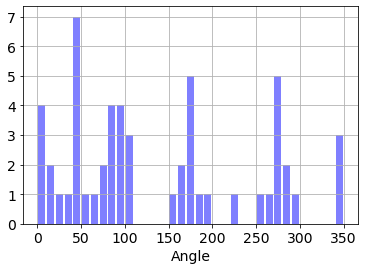

In [425]:
# 히스토그램 출력
bin = np.arange(0, 360, 10)
hist, bin_edges = np.histogram(angle_list, bin)
q = np.sum(hist)

plt.hist(angle_list, bin, rwidth=0.8, color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Angle', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()